In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_traj(num_traj):
    t = []
    vol = []
    trajec_num = []

    for i in range(num_traj):
        t_0 = np.random.uniform(2.5, 3.5)
        t.append(t_0)

        candidate_w_1 = 100
        while candidate_w_1 > 2.5:
            candidate_w_1 = np.random.gamma(1, 1.5)
        t.append(t_0 + candidate_w_1 + 0.5)

        w_2 = np.random.uniform(4, 9)
        t.append(t_0 + candidate_w_1 + 0.5 + w_2)

        v_peak = np.random.uniform(7, 11)
        vol.extend([3, v_peak, 6])

        trajec_num.extend([i, i, i])
    
    df = np.array([t, vol, trajec_num])
    return(df)

In [3]:
def get_y(traj, x):
    m_1 = (traj[1,1] - traj[1,0]) / (traj[0,1] - traj[0,0]) # slope of first line seg
    b_1 = traj[1,1] - (m_1 * traj[0,1]) # y-int of first line seg

    m_2 = (traj[1,2] - traj[1,1]) / (traj[0,2] - traj[0,1]) # slope of second line seg
    b_2 = traj[1,2] - (m_2 * traj[0,2]) # y-int of second line seg

    y = []
    for i in range(len(x)):
        if x[i] <= traj[0, 1]:
            y_i = (m_1 * x[i]) + b_1
        else:
            y_i = (m_2 * x[i]) + b_2
        
        y.append(y_i)
    
    return(y)

In [4]:
def sample_traj(traj, num_samples):
    x = np.random.uniform(traj[0, 0],traj[0, 2], size = num_samples)

    y = get_y(traj, x)

    sampled_pts = np.array([x, y])

    return(sampled_pts)

In [6]:
def compute_beta_red(sampled_pts):
    n = len(sampled_pts[0])
    y_bar = sum(sampled_pts[1]) / n

    total = 0
    for point in sampled_pts.T:
        total += (point[1] - y_bar) * point[0]

    beta = 12 * (total / (n * (n + 1) * (n - 1)))

    return(beta)

In [ ]:
def compute_sigma_red(sampled_pts, beta):
    n = len(sampled_pts[0])

    total = 0
    for point in sampled_pts.T:
        total += point[1] - (beta * point[0])
    
    sigma = total / n

    return(sigma)  

In [8]:
def compute_beta(sampled_pts):
    n = len(sampled_pts[0])

    x_bar = sum(sampled_pts[0]) / n
    y_bar = sum(sampled_pts[1]) / n

    numer = 0
    denom = 0
    for point in sampled_pts.T:
        numer += (point[0] - x_bar) * (point[1] - y_bar)
        denom += (point[0] - x_bar) ** 2
    
    beta = numer / denom

    return(beta)

In [9]:
def compute_sigma(sampled_pts, beta):
    n = len(sampled_pts[0])

    x_bar = sum(sampled_pts[0]) / n
    y_bar = sum(sampled_pts[1]) / n

    sigma = y_bar - (beta * x_bar)

    return(sigma)


In [10]:
def compute_sse_red(sampled_pts):
    beta_red = compute_beta_red(sampled_pts)
    sigma_red = compute_sigma_red(sampled_pts, beta_red)

    sse = 0
    for point in sampled_pts.T:
        sse += (point[1] - sigma_red - (beta_red * point[0])) ** 2
    
    return(sse)

In [11]:
def compute_sse_full(sampled_pts, c):
    row_mask = sampled_pts.T[:, 0] < c

    below_break_pts = sampled_pts.T[row_mask].T
    beta_1 = compute_beta(below_break_pts)
    sigma_1 = compute_sigma(below_break_pts, beta_1)

    above_break_pts = sampled_pts.T[~row_mask].T
    beta_2 = compute_beta(above_break_pts)
    sigma_2 = compute_sigma(above_break_pts, beta_2)

    below_sse = 0
    for point in below_break_pts.T:
        below_sse += (point[1] - sigma_1 - (beta_1 * point[0])) ** 2

    above_sse = 0
    for point in above_break_pts.T:
        below_sse += (point[1] - sigma_2 - (beta_2 * point[0])) ** 2

    sse_full = below_sse + above_sse

    return(sse_full)

In [12]:
def compute_Fc(sampled_pts, c):
    n = len(sampled_pts[0])
    sse_red = compute_sse_red(sampled_pts)
    sse_full = compute_sse_full(sampled_pts, c)
    Fc = ((sse_red - sse_full) / 2) / (sse_full / (n - 4))

    return(Fc)

In [13]:
def changepoint_est_error(num_samples, c_val_step):
    traj = generate_traj(1)

    sampled_pts = sample_traj(traj, num_samples)
    error_x = np.random.normal(0, 0.1, num_samples)
    error_y = np.random.normal(0, 0.1, num_samples)
    sampled_pts = np.array([sampled_pts[0] + error_x, sampled_pts[1] + error_y])   

    c_values = np.arange(sorted(sampled_pts[0])[1] + c_val_step, sorted(sampled_pts[0])[-2], c_val_step)

    max_Fc = 0
    for c in c_values:
        Fc = compute_Fc(sampled_pts, c)
        if Fc > max_Fc:
            max_Fc = Fc
            changepoint = c
    
    if max_Fc == 0:
        return math.inf
    
    return(abs(changepoint - traj[0][1]))

In [16]:
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Simulation 1: Demonstrating the estimation of the changepoint

In [56]:
num_samples = 5
c_val_step = 0.1
traj = generate_traj(1)

sampled_pts = sample_traj(traj, num_samples)
error_x = np.random.normal(0, 0.1, num_samples)
error_y = np.random.normal(0, 0.1, num_samples)
sampled_pts = np.array([sampled_pts[0] + error_x, sampled_pts[1] + error_y])   

c_values = np.arange(sorted(sampled_pts[0])[1] + c_val_step, sorted(sampled_pts[0])[-2], c_val_step)

all_Fc = []
max_Fc = 0
for c in c_values:
    Fc = compute_Fc(sampled_pts, c)
    all_Fc = np.append(all_Fc, Fc)
    if Fc > max_Fc:
        max_Fc = Fc
        changepoint = c

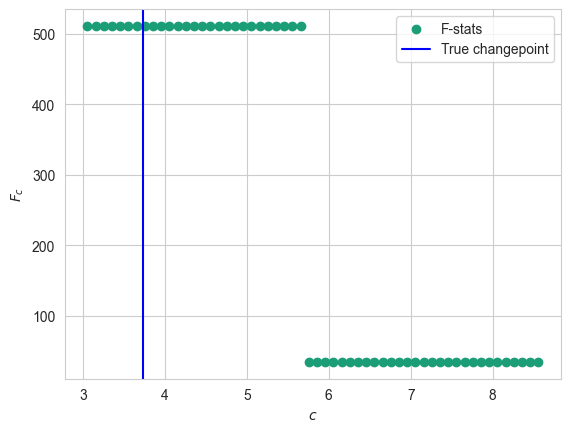

In [57]:
plt.scatter(c_values, all_Fc, label = "F-stats")
plt.axvline(traj[0,1], ymin=0, ymax=500, label = "True changepoint", color = "blue")
plt.xlabel("$c$")
plt.ylabel("$F_c$")
plt.legend()

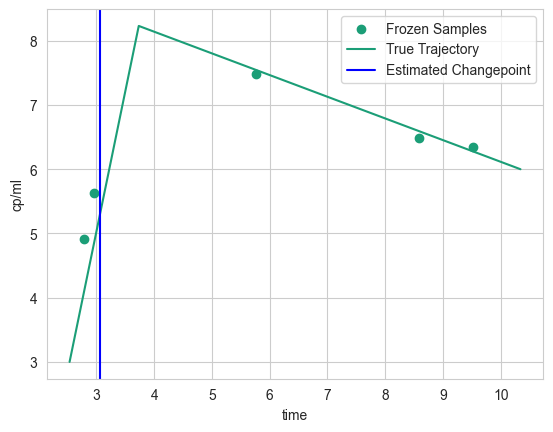

In [59]:
plt.scatter(sampled_pts[0], sampled_pts[1], zorder = 2, label = "Frozen Samples")
plt.plot(traj[0], traj[1], zorder = 1, label = "True Trajectory")
plt.axvline(changepoint, ymin=0, ymax=8, label = "Estimated Changepoint", color = "blue")
plt.xlabel("time")
plt.ylabel("cp/ml")
plt.legend()

# Simulation 2: How many samples do we need to get a good changepoint estimate?

In [18]:
sample_errors = []
num_iterations = 50
for num_samples in range(10, 100, 5):
    n_error = 0
    for iteration in range(num_iterations):
        n_error += changepoint_est_error(num_samples, 0.1)
    mean_n_error = n_error / num_iterations
    sample_errors = np.append(sample_errors, mean_n_error)

Text(0, 0.5, 'distance from $\\hat{c}$ to true c')

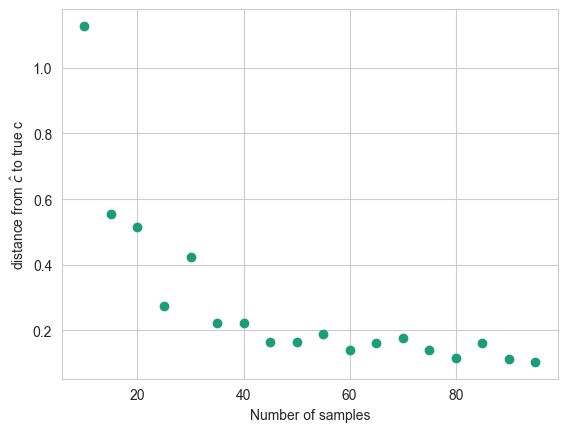

In [22]:
plt.scatter(range(10, 100, 5), sample_errors)
plt.xlabel("Number of samples")
plt.ylabel("distance from $\\hat{c}$ to true c")

In [25]:
sample_errors2 = []
num_iterations = 100
for num_samples in range(5, 15):
    n_error = 0
    for iteration in range(num_iterations):
        n_error += changepoint_est_error(num_samples, 0.1)
    mean_n_error = n_error / num_iterations
    sample_errors2 = np.append(sample_errors2, mean_n_error)

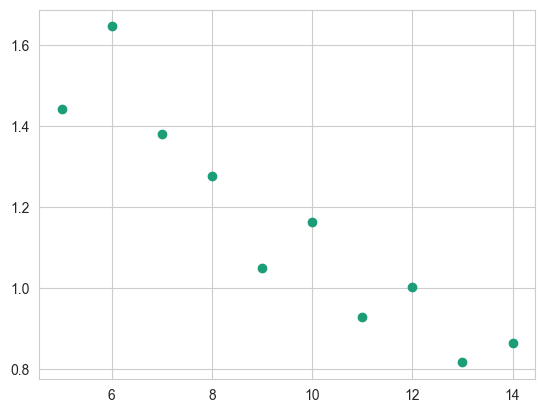

In [26]:
plt.scatter(range(5, 15), sample_errors2)

# Simulation 3: How small of a step size do we need to get a good changepoint estimate?

In [60]:
sample_errors = []
num_iterations = 20
for step_size in np.arange(0.01, 1, 0.05):
    n_error = 0
    for iteration in range(num_iterations):
        n_error += changepoint_est_error(100, step_size)
    mean_n_error = n_error / num_iterations
    sample_errors = np.append(sample_errors, mean_n_error)

Text(0, 0.5, 'distance from $\\hat{c}$ to true c')

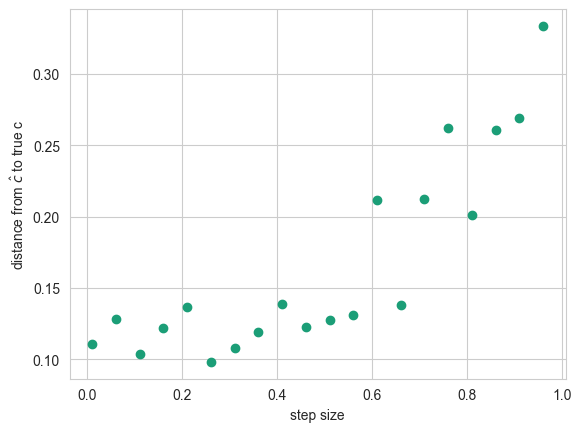

In [61]:
plt.scatter(np.arange(0.01, 1, 0.05), sample_errors)
plt.xlabel("step size")
plt.ylabel("distance from $\\hat{c}$ to true c")